<a href="https://colab.research.google.com/github/chezyio/SC1015_Project/blob/main/SC1015_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

300321 / TDL

1) Reduce the number of pneumonia images to the number of normal images (so as to reduce skewness and biasness)

2) Image processing (skew, roate etc) and train a model that has processed images

3) Compare model that has processed images or non-processed images to see which one is better

4) Work on densenet elaboration

5*) Work on script/structure for video


<br>


X / TDL

1) Start recording video components

2) Edit 

3*) Frontend web app if got time? HAHA

<h1>Detecting Pneumonia using X-Rays</h1>
<div>
  <p>SC1015 Introduction to Data Science and Artificical Intelligence</p>
  <p>B137, Team 10</p>
  <table>
    <tr>
      <th>Name</th>
      <th>Email</th>
    </tr>
    <tr>
      <td>Terri Tan</td>
      <td>X</td>
    </tr>
    <tr>
      <td>Yanping Kung</td>
      <td>X</td>
    </tr>
    <tr>
      <td>Chester Yee</td>
      <td>CYEE006@e.ntu.edu.sg</td>
    </tr>
  </table>
</div>

<h1>Preamble</h1>

 
<p>Pneumonia is an infection that inflames the air sacs in both lungs. It is one of the leading causes of death in Singapore and worldwide. Accounting for 20.7%, 18.8% and 18.4% of deaths in Singapore in 2019,2020 and 2021 according to the death statistics retrieve from HealthHub. As for worldwide, statistics has shown that 2.5 million people have died from pneumonia in 2019.</p> 
<br>
<p>Pneumonia can be caused by viral, bacterial and fungi. Common pneumonias are contagious and can be spread from person to person or through the contact with surfaces or objects that are contaminated by the bacteria or viruses. One example of a viral infections that can cause pneumonia which is common now is the coronavirus infection </p>
<br>
<p> However upon proper detection and treatment, many cases of pneumonia can be cleared without complications. One of the effective ways to identify signs of an inflammation will be Chest X-ray. Through x-rays, doctors will also be able to know the location and extent of this inflammation. </p>
<br>
<p> For the treatment of mild Pneumonia, it can be easily done through antibiotic, antiviral or antifungal medications.  In the case of any underlining health issues, one might be hospitalized and receive treatments such as respiratory and oxygen therapy and will be required to be injected with antibiotics.  </p>


` try link back to singapore cannn?`

<h1>Problem Statement</h1>
How might we _____do what____ for ____person____ in order to ____ 



In [ ]:
%%capture
!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install -q kaggle

<h1>Import Libraries</h1>

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from numpy import asarray
import os
import cv2


# Deep Learning
import keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, load_model, Model
from keras.applications.densenet import DenseNet121

In [ ]:
# Kaggle API Key 
os.environ['KAGGLE_USERNAME'] = "territellis"
os.environ['KAGGLE_KEY'] = "c9fcf5c0a806a25124e165d1530b3d75"

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:23<00:00, 30.1MB/s]
100% 2.29G/2.29G [01:23<00:00, 29.6MB/s]


In [ ]:
%%capture
!unzip chest-xray-pneumonia.zip -d chest_xray

<h1>Exploratory Data Analysis</h1>
<ul>
  <li>Explore the number of images in train, test and validation folders -- HALFWAY (need to add boxplot for test and validation)</li>
  <li>Explore the pixel density distribution of a normal person and a person who has pneumonia -- DONE</li>
<ul>

`Any other we can add or explore? hmmm`


In [ ]:
train = './chest_xray/chest_xray/train/'
test = './chest_xray/chest_xray/test/'
val = './chest_xray/chest_xray/val/'

trainN = train + 'NORMAL/'
trainP = train + 'PNEUMONIA/'

testN = test + 'NORMAL/'
testP = test + 'PNEUMONIA/'

valN = val + 'NORMAL/'
valP = val + 'PNEUMONIA/'

Text(0.5, 1.0, 'Pneumonia')

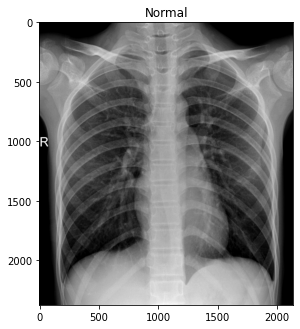

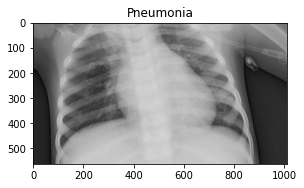

In [ ]:
def randomImage(trainSet):
  rand_norm = np.random.randint(0,len(os.listdir(trainSet)))
  pic = os.listdir(trainSet)[rand_norm]
  #print('normal picture title: ', pic)

  pic_add = trainSet+pic

  # rand_p = np.random.randint(0, len(os.listdir(trainP)))

  # pneu_pic = os.listdir(trainP)[rand_p]
  # pneu_pic_add = trainP + pneu_pic
  # print('pneumonia picture title: ', pneu_pic)

  # Load images
  load_image = Image.open(pic_add)
  #pneu_load = Image.open(pneu_pic_add)

  return load_image

f = plt.figure(figsize = (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(randomImage(trainN), cmap='gray')
a1.set_title('Normal')

f2 = plt.figure(figsize =(10,10))
a2 = f2.add_subplot(1,2,1)
img_plot2 = plt.imshow(randomImage(trainP), cmap='gray')
a2.set_title('Pneumonia')

In [ ]:
def distPlot(trainSet):
  load_image = randomImage(trainSet)
  load_array = asarray(load_image)
  sns.distplot(load_array.ravel(),
              label=f"Pixel Mean {np.mean(load_image):.3f} & Standard Deviation {np.std(load_image):.3f}", 
              kde=False)
  plt.legend(loc='upper right')
  plt.title('Distribution of Pixel Intensities in the Image')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('# Pixels in Image')

<ipython-input-8-aea13831a990>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(load_array.ravel(),


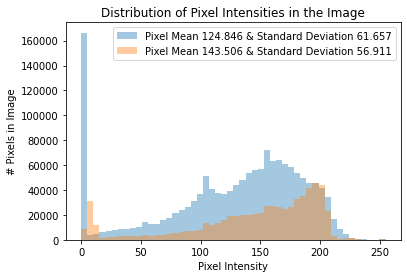

In [ ]:
distPlot(trainN)
distPlot(trainP)

There are 5216 images in the training dataset
There are 624 images in the test dataset
There are 16 images in the validation dataset


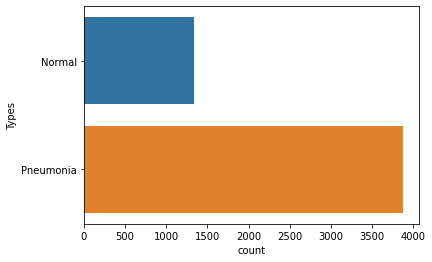

In [ ]:
n_count = len(os.listdir(trainN))
p_count = len(os.listdir(trainP))

print("There are {} images in the training dataset".format(len(os.listdir(trainN) + os.listdir(trainP))))
print("There are {} images in the test dataset".format(len(os.listdir(testN) + os.listdir(testP))))
print("There are {} images in the validation dataset".format(len(os.listdir(valN) + os.listdir(valP))))


df = pd.DataFrame({'Types': ['Normal', 'Pneumonia'], 'count':[n_count, p_count]})
sns.barplot(x=df['count'], y=df['Types'], orient='h')
plt.show()

<h1>Image Processing</h1>

<ul>
  <li>Resize -- PENDING</li>
  <li>Rescale -- PENDING</li>
<ul>

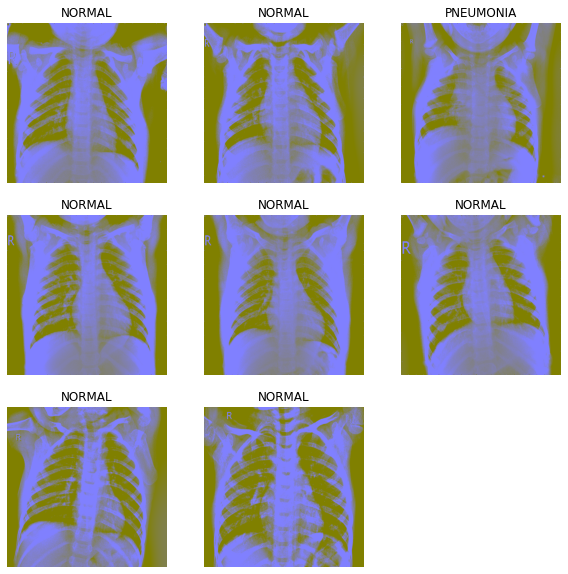

In [ ]:
fig1=plt.figure(figsize=(10,10))
for i in range(len(nVal)):
  img = cv2.imread(val + 'NORMAL/' + nVal[i])
  img = cv2.resize(img, (512, 512))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
  fig1.add_subplot(3, 3, i+1)
  plt.imshow(img)
  plt.title("{}" .format(label[i][0]))
  plt.axis("off")

# plt.figure(figsize=(10,10))
# for i in range(len(pVal)):
#   img = cv2.imread(val + 'PNEUMONIA/' + pVal[i])
#   img = cv2.resize(img, (512, 512))
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#   img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
#   ax = plt.subplot(3, 3, i+1)
#   plt.imshow(img)
#   plt.title("{}" .format(label[i][0]))
#   plt.axis("off")

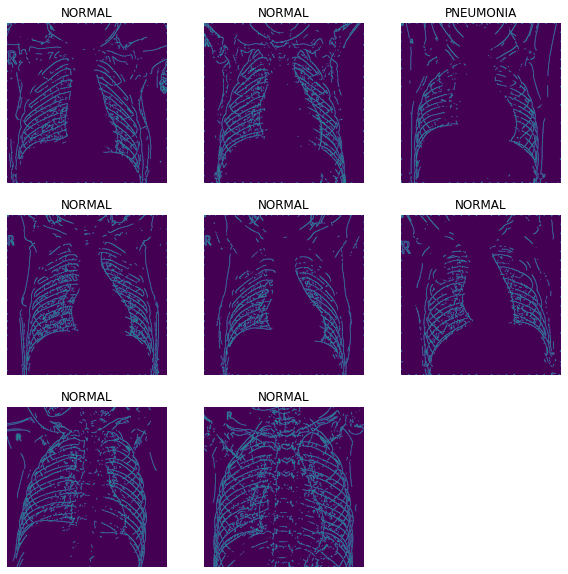

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(nVal)):
  img = cv2.imread(val + 'NORMAL/' + nVal[i])
  img = cv2.resize(img, (512, 512))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  detected_edges = cv2.Canny(img, 80, 100)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(detected_edges)
  plt.title("{}" .format(label[i][0]))
  plt.axis("off")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']
(32, 64, 64, 3)
(32,)


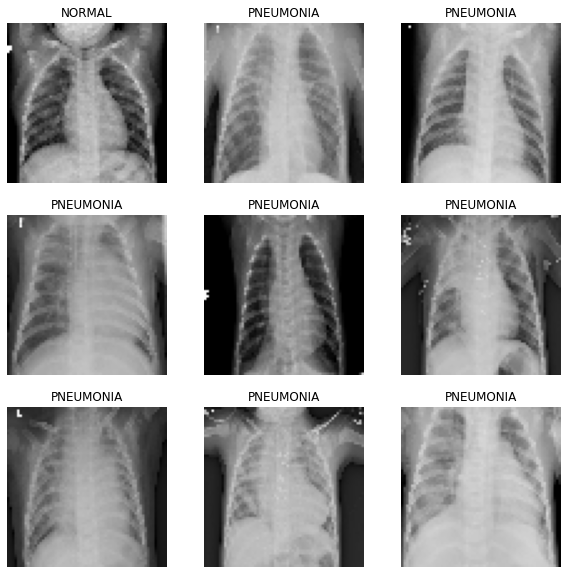

In [ ]:
batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# The image_batch is a tensor of the shape (32, 64, 64, 3). This is a batch of 32 images of shape 64x64x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

<h1>Convolutional Neural Network (CNN)</h1>

<p>CNN is a type of neural network that are specifically designed for processing data that has a grid-like structure, such as images, video, and audio. CNNs are commonly used for image classification, object detection, and segmentation tasks.</p>

<p>CNNs are trained using backpropagation and stochastic gradient descent to minimize a loss function. During training, the weights of the filters and the fully connected layers are updated iteratively to improve the network's performance.</p>

<p>The three main types of layers in a CNN are:</p>


<h4>Convolutional Layers</h4>
<p>Convolutional layers apply a set of learnable filters to the input data to extract features that are important for the task at hand. Each filter slides over the input data and performs element-wise multiplication followed by summation to produce a single value, which is then passed through an activation function. The output of a convolutional layer is a set of feature maps that represent different aspects of the input data.</p>

<br>

<h4>Pooling Layers</h4>
<p>These layers downsample the feature maps by taking the maximum, average, or other function of a local region. This reduces the dimensionality of the feature maps while retaining the important information.</p>

<br>

<h4>Fully Connected Layers</h4>
<p>Fully Connected layers perform a classification task on the features extracted by the previous layers. Each neuron in a fully connected layer is connected to all the neurons in the previous layer.</p>

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*vkQ0hXDaQv57sALXAJquxA.jpeg'>


<img src='https://miro.medium.com/v2/resize:fit:1052/1*GcI7G-JLAQiEoCON7xFbhg.gif'>

<img src='https://miro.medium.com/v2/resize:fit:1192/format:webp/1*KQIEqhxzICU7thjaQBfPBQ.png'>


<h4>Technical Specifications</h4>

  <p>3 convolution layers with max pool and dropout after each convolution, use 2 fully connected layers to construct multii-layer perceptron network</p>
</div>



<h1>Train Model</h1>

In [ ]:
# relu = values would range from 0 to infinity, any negative values would be treated as 0
# sigmoid = values would range from 0 to 1


# RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
# RandomRotation(0.1),
# RandomZoom(0.1),
# Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # [0,1] range


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  # Convolution Layer: 32 filters, 3x3 kernel size, relu activation function, 64x64 image with depth of 3 as input
  Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),

  # Pooling Layer: 2x2 kernel size using max pool
  MaxPooling2D(pool_size = (2, 2)),

  # Dropout Layer: 
  Dropout(0.2),

  # Convolution Layer: 64 filters, 3x3 kernel size, relu activation function
  Conv2D(64, (3, 3), activation="relu"),

  # Pooling Layer: 2x2 kernel size using max pool
  MaxPooling2D(pool_size = (2, 2)),

  # Dropout Layer:
  Dropout(0.2),

  # Convolution Layer: 128 filters, 3x3 kernel size, relu activation function
  Conv2D(128, (3, 3), activation="relu"),

  # Pooling Layer: 2x2 kernel size using max pool
  MaxPooling2D(pool_size = (2, 2)),

  # Dropout Layer:
  Dropout(0.2),

  # Flatten into 1D
  Flatten(),

  # Fully Connected Layers: 
  Dense(activation = 'relu', units = 128),
  Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
163/163 [==============================] - 72s 251ms/step - loss: 5.2458 - accuracy: 0.7632 - val_loss: 0.6203 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 41s 252ms/step - loss: 0.3045 - accuracy: 0.8687 - val_loss: 0.5146 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 46s 280ms/step - loss: 0.2130 - accuracy: 0.9118 - val_loss: 0.3909 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 42s 260ms/step - loss: 0.1864 - accuracy: 0.9245 - val_loss: 0.3667 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 43s 262ms/step - loss: 0.1457 - accuracy: 0.9434 - val_loss: 0.2783 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 41s 255ms/step - loss: 0.1470 - accuracy: 0.9434 - val_loss: 0.3129 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 43s 263ms/step - loss: 0.1322 - accuracy: 0.9490 - val_loss: 0.1957 - val_ac

<h1>Evaluate Model</h1>
<p>Based on the perfomance of model, we can deduce that the CNN model is rather accurate as the validation accuracy is closely follows the training accuracy. When comparing the training and validation loss, it also shows that the validation loss closely follows the training loss overtime. In order to maximise the training and validation accuracy, we have performed a hyperparameter tuning as well and this was the result. When tuning the hyperparameters, we were also mindful of the fact that over tuning the model could result in overfitting and under tuning the model could result in underfitting.</p> 

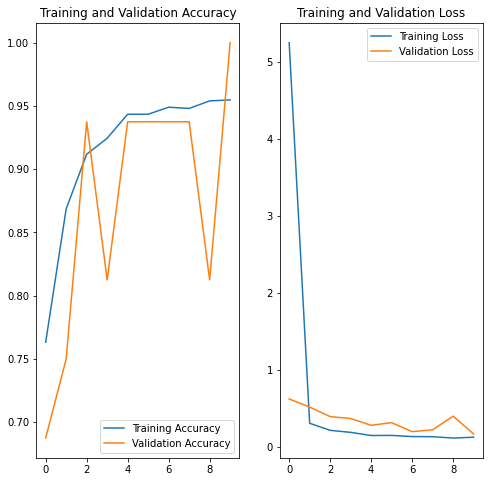

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#test_path = val + 'NORMAL/NORMAL2-IM-1438-0001.jpeg'
test_path = val + 'PNEUMONIA/person1949_bacteria_4880.jpeg'

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))


loss, acc = model.evaluate(test_ds)


1/1 [==============================] - 0s 181ms/step
This image most likely belongs to PNEUMONIA with a 67.51 percent confidence.
20/20 [==============================] - 5s 184ms/step - loss: 0.4964 - accuracy: 0.8157



IMAGE 1: NORMAL2-IM-1430-0001.jpeg
1/1 [==============================] - 0s 27ms/step

IMAGE 2: NORMAL2-IM-1436-0001.jpeg
1/1 [==============================] - 0s 26ms/step

IMAGE 3: NORMAL2-IM-1437-0001.jpeg
1/1 [==============================] - 0s 23ms/step

IMAGE 4: NORMAL2-IM-1431-0001.jpeg
1/1 [==============================] - 0s 24ms/step

IMAGE 5: NORMAL2-IM-1427-0001.jpeg
1/1 [==============================] - 0s 24ms/step

IMAGE 6: NORMAL2-IM-1438-0001.jpeg
1/1 [==============================] - 0s 22ms/step

IMAGE 7: NORMAL2-IM-1442-0001.jpeg
1/1 [==============================] - 0s 25ms/step

IMAGE 8: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 24ms/step


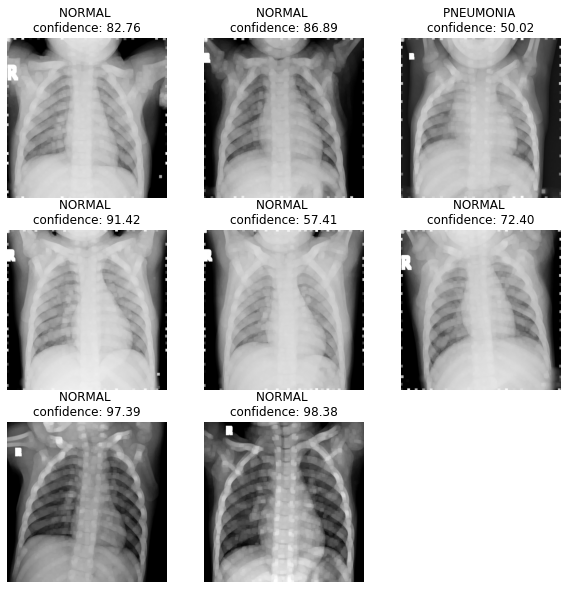

In [ ]:
# Val Normal Dataset
nVal = [x for x in os.listdir(val + 'NORMAL')]
count = 1

label = []
for image in nVal:
  imgFilePath = val + 'NORMAL/' + image
  print("\nIMAGE " + str(count) + ": " + image)
  img = tf.keras.utils.load_img(
    imgFilePath, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  lbl2 = []
  lbl2.append(class_names[np.argmax(score)])
  lbl2.append(100 * np.max(score))
  label.append(lbl2)
  #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
  count+=1

plt.figure(figsize=(10,10))
for i in range(len(nVal)):
  # loadImg = Image.open(val + 'NORMAL/' + nVal[i])
  ax = plt.subplot(3, 3, i+1)
  # plt.imshow(loadImg, cmap='gray')
  img = cv2.imread(val + 'NORMAL/' + nVal[i])
  img = cv2.resize(img, (512, 512))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  kernel = np.ones((5, 5), np.uint8)
  image_dilation = cv2.dilate(img, kernel, iterations = 2)
  plt.imshow(image_dilation)
  plt.title("{} \nconfidence: {:.2f}" .format(label[i][0], label[i][1]))
  plt.axis("off")
    


IMAGE 1: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 105ms/step

IMAGE 2: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 36ms/step

IMAGE 3: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 36ms/step

IMAGE 4: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 24ms/step

IMAGE 5: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 26ms/step

IMAGE 6: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 26ms/step

IMAGE 7: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 25ms/step

IMAGE 8: NORMAL2-IM-1440-0001.jpeg
1/1 [==============================] - 0s 24ms/step


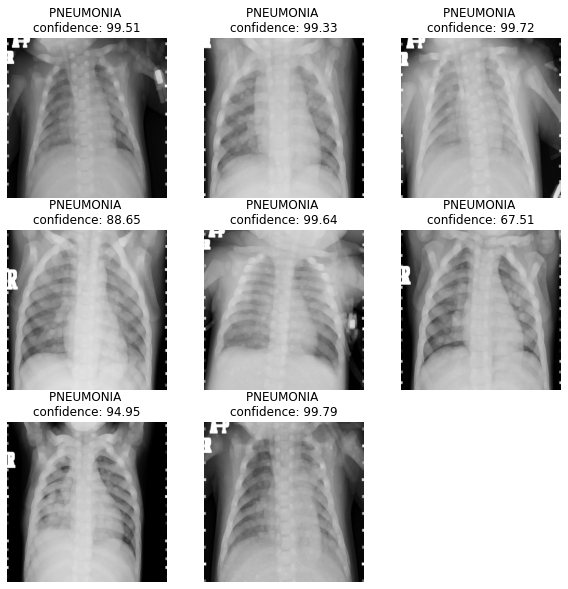

In [ ]:
# Val Pneumonia Dataset
pVal = [p for p in os.listdir(val + 'PNEUMONIA')]
count = 1
label = []
for imagePath in pVal:
  test_path = val + 'PNEUMONIA/' + imagePath
  print("\nIMAGE " + str(count) + ": " + image)
  img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  lbl2 = []
  lbl2.append(class_names[np.argmax(score)])
  lbl2.append(100 * np.max(score))
  label.append(lbl2)
  #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
  count+=1

plt.figure(figsize=(10,10))
for i in range(len(pVal)):
  # loadImg = Image.open(val + 'PNEUMONIA/' + pVal[i])
  # ax = plt.subplot(3, 3, i+1)
  # plt.imshow(loadImg, cmap='gray')
  # plt.title("{} \nconfidence: {:.2f}" .format(label[i][0], label[i][1]))
  # plt.axis("off")
  ax = plt.subplot(3, 3, i+1)
  img = cv2.imread(val + 'PNEUMONIA/' + pVal[i])
  img = cv2.resize(img, (512, 512))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  kernel = np.ones((5, 5), np.uint8)
  image_dilation = cv2.dilate(img, kernel, iterations = 2)
  plt.imshow(image_dilation)
  plt.title("{} \nconfidence: {:.2f}" .format(label[i][0], label[i][1]))
  plt.axis("off")

<h1>Densely Connected Convolutional Network (DenseNet)</h1>

<p>DenseNet takes all previous output as an input for a future layer 


In [ ]:
base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.summary()

In [ ]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

In [ ]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  train,
    labels = "inferred",
    label_mode = "categorical",
    color_mode = "rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test,
    labels = "inferred",
    label_mode = "categorical",
    color_mode = "rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  val,
        labels = "inferred",
    label_mode = "categorical",
    color_mode = "rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
%%script false

from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout


optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model
densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:101]:    
    layer.trainable = False

for layer in densed_Model.layers[101:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
h2 = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=[early_stoppage,lrs])

model.summary()

model.save('./model/denseNet121/denseNetModel.h5')
model.save_weights('./model/denseNet121/denseNetWeights.h5')

Epoch 1/30
163/163 [==============================] - 180s 989ms/step - loss: 0.2544 - accuracy: 0.9030 - val_loss: 0.2433 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - 201s 1s/step - loss: 0.1244 - accuracy: 0.9620 - val_loss: 0.8694 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - 248s 2s/step - loss: 0.0730 - accuracy: 0.9799 - val_loss: 0.1681 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 4/30
163/163 [==============================] - 267s 2s/step - loss: 0.0502 - accuracy: 0.9873 - val_loss: 0.3036 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 5/30
163/163 [==============================] - 263s 2s/step - loss: 0.0381 - accuracy: 0.9895 - val_loss: 0.4459 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 6/30
163/163 [==============================] - 259s 2s/step - loss: 0.0384 - accuracy: 0.9885 - val_loss: 0.1995 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 7/30
163/163 [=================

Text(0.5, 1.0, 'Training and Validation Accuracy')

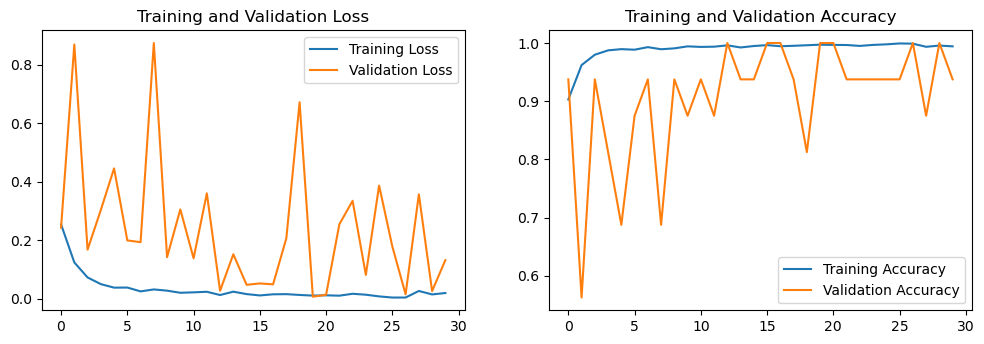

In [ ]:
%%script false

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(h2.history['loss'], label='Training Loss')
plt.plot(h2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(h2.history['accuracy'], label='Training Accuracy')
plt.plot(h2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


<h1>Conclusion</h1>

<h1>Acknowledgements</h1>

Dataset https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia